For more details, see this [repo](https://github.com/PPPW/deep-learning-random-explore/tree/master/CNN_archs).

### Add Fast AI path to environment

In [1]:
import os
import sys
sys.path.append(os.environ.get("FASTAI_PATH"))

In [2]:
from fastai.vision import *
from fastai.callbacks import *

In [3]:
data_path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
data = (
    ImageList.from_folder(data_path) # images path
    .split_by_folder() # split train and valid datasets by folder
    .label_from_folder()  # get labels from folder name
    .transform(size=28) # resize each image to 28x28
    .databunch(bs=256) # batch size 256
    .normalize(imagenet_stats) # normalize images with mean and std from IMageNet
)

### Use the pretrained model provided by `Cadene`

In [5]:
import pretrainedmodels
pretrainedmodels.model_names

['fbresnet152',
 'bninception',
 'resnext101_32x4d',
 'resnext101_64x4d',
 'inceptionv4',
 'inceptionresnetv2',
 'alexnet',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'inceptionv3',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19_bn',
 'vgg19',
 'nasnetamobile',
 'nasnetalarge',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn131',
 'dpn107',
 'xception',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'cafferesnet101',
 'pnasnet5large',
 'polynet']

In [6]:
def resnext101_32x4d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.resnext101_32x4d(pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers[0], *all_layers[1:])

In [9]:
_resnext_meta = {'cut': -2, 'split': lambda m: (m[0][6], m[1]) }
from fastai.vision.learner import model_meta
model_meta[resnext101_32x4d] = _resnext_meta

In [10]:
learn = cnn_learner(data, resnext101_32x4d, metrics=error_rate)

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


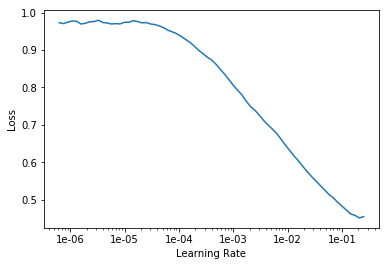

In [12]:
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(3, 5E-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.117387,0.082701,0.030913,00:12
1,0.048418,0.010490,0.002453,00:11
2,0.021485,0.003278,0.000491,00:10


In [14]:
learn.unfreeze()
best_model = "mnist_sample_resnet34"
learn.fit_one_cycle(10, slice(1E-6, 1E-3), callbacks=[SaveModelCallback(learn, name=best_model, monitor="error_rate", mode="min")])

epoch,train_loss,valid_loss,error_rate,time
0,0.001624,0.003206,0.000491,00:20
1,0.002390,0.000072,0.000000,00:19
2,0.004129,0.002465,0.000491,00:19
3,0.002254,0.003224,0.000491,00:19
4,0.001473,0.008631,0.001472,00:19
5,0.001402,0.004049,0.000981,00:19
6,0.001011,0.002404,0.000491,00:19
7,0.000808,0.002263,0.000491,00:19
8,0.000381,0.003325,0.000491,00:19
9,0.000176,0.002591,0.000491,00:19


Better model found at epoch 0 with error_rate value: 0.0004906843532808125.
Better model found at epoch 1 with error_rate value: 7.19467241339089e-09.


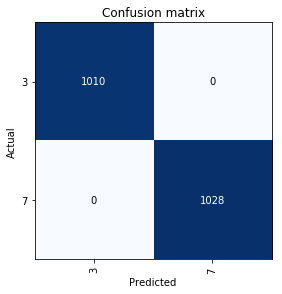

In [15]:
interp = learn.interpret()
interp.plot_confusion_matrix()

### Use the pretrained model provided by `pytorchcv`

In [30]:
from pytorchcv.model_provider import get_model as ptcv_get_model

In [31]:
def efficientnet_b0(pretrained=False):
    return ptcv_get_model("efficientnet_b0", pretrained=False).features

In [32]:
learn = cnn_learner(data, efficientnet_b0, pretrained=False,
                    cut=noop, split_on=lambda m: (m[0][4], m[1]), metrics=error_rate)

In [33]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


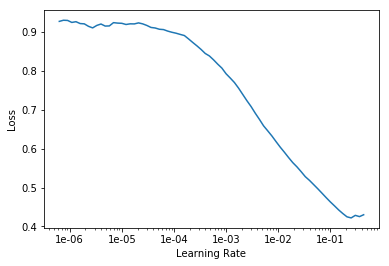

In [34]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(20, 5E-2, callbacks=[SaveModelCallback(learn, name=best_model, monitor="error_rate", mode="min")])

epoch,train_loss,valid_loss,error_rate,time
0,0.141991,0.331875,0.013739,00:06
1,0.058911,0.022595,0.005888,00:06
2,0.048765,0.079160,0.016192,00:06
3,0.035435,0.018104,0.003435,00:06
4,0.056755,1.732001,0.053974,00:06
5,0.692834,8.387109,0.144259,00:06
6,0.313832,0.039846,0.012758,00:06
7,0.141662,0.197490,0.060844,00:06
8,0.065519,0.050395,0.015702,00:06
9,0.033001,0.015890,0.005888,00:06


Better model found at epoch 0 with error_rate value: 0.013738967478275299.
Better model found at epoch 1 with error_rate value: 0.005888132844120264.
Better model found at epoch 3 with error_rate value: 0.0034347467590123415.
Better model found at epoch 15 with error_rate value: 0.002453392371535301.
Better model found at epoch 16 with error_rate value: 0.001962715294212103.


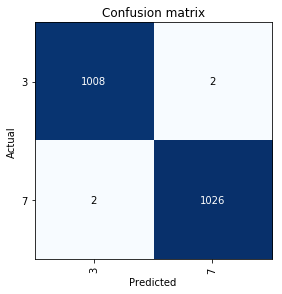

In [36]:
interp = learn.interpret()
interp.plot_confusion_matrix()